<a href="https://colab.research.google.com/github/NastyaTataurova/recommendation_system/blob/main/rec_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d grouplens/movielens-20m-dataset
!unzip /content/movielens-20m-dataset.zip

In [ ]:
!pip install pyspark
!pip install lightfm
!pip install catboost

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy.stats import wilcoxon

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.recommendation import ALS

from lightfm.data import Dataset
from lightfm import LightFM
from catboost import CatBoostRegressor

from tqdm.notebook import tqdm

In [41]:
tag = pd.read_csv('tag.csv')
rating = pd.read_csv('rating.csv')
movie = pd.read_csv('movie.csv')
link = pd.read_csv('link.csv')
genome_tags = pd.read_csv('genome_tags.csv')
genome_scores = pd.read_csv('genome_scores.csv')

## Посмотрим на данные

In [15]:
tag.shape, rating.shape, movie.shape, link.shape, genome_tags.shape, genome_scores.shape

((465564, 4), (20000263, 4), (27278, 3), (27278, 3), (1128, 2), (11709768, 3))

In [15]:
rating.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [16]:
print('\ntag')
display(tag.head())
print('\nrating')
display(rating.head())
print('\nmovie')
display(movie.head())
print('\nlink')
display(link.head())
print('\ngenome_tags')
display(genome_tags.head())
print('\ngenome_scores')
display(genome_scores.head())


tag


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18



rating


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40



movie


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



link


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0



genome_tags


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s



genome_scores


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [17]:
print('tag')
display(tag.info())
print('rating')
display(rating.info())
print('movie')
display(movie.info())
print('link')
display(link.info())
print('genome_tags')
display(genome_tags.info())
print('genome_scores')
display(genome_scores.info())

tag
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465564 non-null  int64 
 1   movieId    465564 non-null  int64 
 2   tag        465548 non-null  object
 3   timestamp  465564 non-null  object
dtypes: int64(2), object(2)
memory usage: 14.2+ MB


None

rating
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


None

movie
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


None

link
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB


None

genome_tags
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


None

genome_scores
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB


None

In [18]:
print('tag')
display(tag.describe())
print('rating')
display(rating.describe())
print('movie')
display(movie.describe())
print('link')
display(link.describe())
print('genome_tags')
display(genome_tags.describe())
print('genome_scores')
display(genome_scores.describe())

tag


,userId,movieId
count,465564.000000,465564.000000
mean,68712.354263,32627.762920
std,41877.674053,36080.241157
min,18.000000,1.000000
25%,28780.000000,2571.000000
50%,70201.000000,7373.000000
75%,107322.000000,62235.000000
max,138472.000000,131258.000000


rating


,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


movie


,movieId
count,27278.000000
mean,59855.480570
std,44429.314697
min,1.000000
25%,6931.250000
50%,68068.000000
75%,100293.250000
max,131262.000000


link


,movieId,imdbId,tmdbId
count,27278.000000,2.727800e+04,27026.000000
mean,59855.480570,5.781860e+05,63846.683083
std,44429.314697,7.804707e+05,69862.134497
min,1.000000,5.000000e+00,2.000000
25%,6931.250000,7.741725e+04,15936.500000
50%,68068.000000,1.524350e+05,39468.500000
75%,100293.250000,9.062715e+05,82504.000000
max,131262.000000,4.530184e+06,421510.000000


genome_tags


,tagId
count,1128.000000
mean,564.500000
std,325.769857
min,1.000000
25%,282.750000
50%,564.500000
75%,846.250000
max,1128.000000


genome_scores


,movieId,tagId,relevance
count,1.170977e+07,1.170977e+07,1.170977e+07
mean,2.584297e+04,5.645000e+02,1.164833e-01
std,3.467615e+04,3.256254e+02,1.542463e-01
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,2.926000e+03,2.827500e+02,2.425000e-02
50%,6.017000e+03,5.645000e+02,5.650000e-02
75%,4.606200e+04,8.462500e+02,1.415000e-01
max,1.311700e+05,1.128000e+03,1.000000e+00


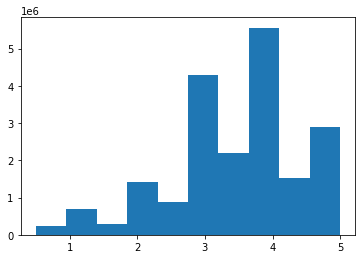

In [38]:
plt.hist(rating.rating);

## Выбор метрики

Необходимо спрогнозировать оценку пользователя к фильму и сравнить ее с фактической оценкой, которую поставил пользователь. Для того, чтобы проверить качество прогноза, я буду использовать метрику RMSE, т.к. она покажет различия (неточность) между прогнозируемым рейтингом и фактическим рейтингом. RMSE сложно интерпретировать, но с ее помощью можно сравнить качество моделей между собой и выбрать лучшую.

## Разбиение данных

In [3]:
# timestamp to datetime
rating.timestamp = pd.to_datetime(rating.timestamp)
# categorical
# rating['userId'] = rating['userId'].astype("category")
# rating['movieId'] = rating['movieId'].astype("category")

In [18]:
rating.groupby(['userId'])['timestamp'].max()

userId
1        2005-04-02 23:56:41
2        2000-11-21 15:36:54
3        1999-12-14 12:54:59
4        1996-08-24 09:40:54
5        1996-12-26 16:28:48
                 ...        
138489   2012-11-15 14:36:19
138490   2000-11-30 00:52:56
138491   2009-07-09 23:49:07
138492   2005-05-06 03:50:50
138493   2010-01-01 20:42:52
Name: timestamp, Length: 138493, dtype: datetime64[ns]

In [19]:
rating.userId.value_counts().min()

20

Так как даты последних действий для всех пользователей имеют очень большой разброс (у кого-то 2000 год, у кого-то 2010 и др.), невозможно взять какой-то один промежуток времени (например неделю) для валидации на всех пользователях. Необходим индивидуальный промежуток времени для каждого пользователя. Поэтому разобъем данные на обучение и валидацию хронологическим способом: оставим в валидационной выборке только последние действия пользователя

In [4]:
# split data
rating_test = rating.groupby(['userId']).tail(5)
rating_train = rating.drop(index=rating_test.index)

## Коллаборативный подход

ALS (Implicit ALS)

### Работа с данными

In [42]:
spark = SparkSession.builder.appName('movie_rec').getOrCreate()

# drop timestamp and convert to Spark DataRfame
rating_test.drop('timestamp', axis=1).to_csv('rating_test.csv')
rating_train.drop('timestamp', axis=1).to_csv('rating_train.csv')

rating_train = spark.read.csv('rating_train.csv', inferSchema=True, header=True)
rating_test = spark.read.csv('rating_test.csv', inferSchema=True, header=True)

### Построение модели

In [43]:
def get_als_scores(maxIter, regParam, implicitPrefs=False):
    als = ALS(maxIter=maxIter,
          regParam=regParam,
          # rank=rank,
          userCol="userId",
          itemCol="movieId",
          ratingCol="rating",
          coldStartStrategy="drop",
          nonnegative=True,
          implicitPrefs=implicitPrefs,
         )

    model = als.fit(rating_train)
    prediction = model.transform(rating_test)

    eval = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
    rmse = eval.evaluate(prediction)
    print(f'RMSE: {rmse}')

    if implicitPrefs:
      return {'model': 'Implicit ALS', 'maxIter': maxIter, 'regParam': regParam, 'RMSE': rmse}
    else:
      return {'model': 'ALS', 'maxIter': maxIter, 'regParam': regParam, 'RMSE': rmse}

#### ALS

In [7]:
all_result = []

In [8]:
all_result += [get_als_scores(maxIter=5, regParam=0.01)]

RMSE: 0.9240624436835753


In [9]:
all_result += [get_als_scores(maxIter=5, regParam=0.1)]

RMSE: 0.9508986270160082


In [10]:
all_result += [get_als_scores(maxIter=7, regParam=0.01)]

RMSE: 0.9234821480659061


In [11]:
all_result += [get_als_scores(maxIter=7, regParam=0.1)]

RMSE: 0.9273634304512639


In [12]:
all_result += [get_als_scores(maxIter=10, regParam=0.01)]

RMSE: 0.9228774522734334


In [6]:
all_result += [get_als_scores(maxIter=10, regParam=0.1)]

RMSE: 0.907835723286024


In [17]:
# prediction.show()

+--------+------+-------+------+-------------------+----------+
|     _c0|userId|movieId|rating|          timestamp|prediction|
+--------+------+-------+------+-------------------+----------+
|     420|     3|   3098|   4.0|1999-12-11 13:21:08| 4.0697775|
|11607876| 80156|   4291|   5.0|2001-11-11 19:02:55| 4.7082715|
|     173|     1|   8961|   4.0|2005-04-02 23:47:09|  3.775325|
|11608318| 80158|   4896|   4.0|2001-12-09 10:15:22|  3.102037|
|     419|     3|   3072|   4.0|1999-12-11 13:22:47| 3.4151905|
|11608052| 80157|   4027|   5.0|2001-03-29 20:02:49| 3.9017725|
|     172|     1|   8690|   3.5|2005-04-02 23:33:15| 3.5678248|
|     170|     1|   8507|   5.0|2004-09-10 03:13:47|  3.565948|
|     418|     3|   3070|   4.0|1999-12-11 13:42:09|  3.782572|
|11608317| 80158|   4887|   2.0|2001-12-09 10:33:31| 2.4266918|
|11607877| 80156|   4499|   3.0|2001-11-11 18:51:21| 4.4018426|
|     171|     1|   8636|   4.5|2005-04-02 23:44:53| 3.5583303|
|     512|     5|   1196|   5.0|1996-12-

#### Implicit ALS

In [5]:
all_result += [get_als_scores(maxIter=5, regParam=0.01, implicitPrefs=True)]

RMSE: 3.624505495854262


In [6]:
all_result += [get_als_scores(maxIter=10, regParam=0.01, implicitPrefs=True)]

RMSE: 3.6187798087925938


### Вывод по коллаборативному подходу

In [15]:
pd.DataFrame(all_result)

,RMSE,maxIter,model,regParam
0,0.924062,5,ALS,0.01
1,0.950899,5,ALS,0.10
2,0.923482,7,ALS,0.01
3,0.927363,7,ALS,0.10
4,0.922877,10,ALS,0.01
5,0.907836,10,ALS,0.10
6,3.624505,5,Implicit ALS,0.01
7,3.618780,10,Implicit ALS,0.01


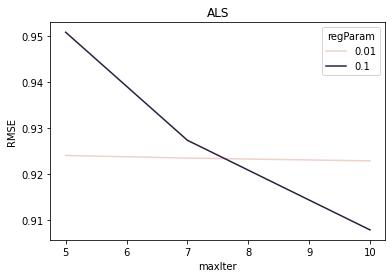

In [25]:
sns.lineplot(
    data=pd.DataFrame(all_result).drop('model', axis=1)[:-2],
    x='maxIter',
    y='RMSE',
    hue='regParam'
    ).set_title('ALS');

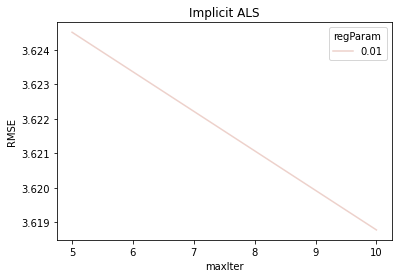

In [26]:
sns.lineplot(
    data=pd.DataFrame(all_result).drop('model', axis=1)[-2:],
    x='maxIter',
    y='RMSE',
    hue='regParam'
    ).set_title('Implicit ALS');

implicit ALS показало самое плохое качетсво (RMSE=3.6), модель ALS справилась с задачей гораздно лучше.

Качество лучше у ALS с параметрами maxIter=10, regParam=0.1 (RMSE=0.91).

## Коллаборативный + контентный подход

LightFM + CatBoost

### Работа с данными

In [4]:
# the code that was above
rating = pd.read_csv('rating.csv')

# timestamp to datetime
rating.timestamp = pd.to_datetime(rating.timestamp)

# train test split
rating_test = rating.groupby(['userId']).tail(5)
rating_train = rating.drop(index=rating_test.index)

In [5]:
# create separate column 'year'
movie['year'] = movie.title.apply(lambda x: x.split()[-1][1:5])
movie.drop([i for i in range(movie.shape[0]) if not movie.year[i].isdecimal()], inplace=True)
movie['year'] = movie['year'].astype(int)
movie['title'] = movie.title.apply(lambda x: x[:-6])

# create separate columns with genres
# genres_set = set()
# for gen in movie.genres.apply(lambda x: x.split('|')):
#   genres_set = genres_set | set(gen)

# for gen in genres_set:
#   movie[gen] = [int(gen in i) for i in movie.genres]

# movie.drop('genres', axis=1, inplace=True)

In [69]:
rating_train.shape, movie.shape, link.shape

((19307798, 4), (27255, 4), (27278, 3))

In [70]:
# join data from different tables
# merge movie data
train = pd.merge(rating_train, movie, on='movieId', how='left')
test = pd.merge(rating_test, movie, on='movieId', how='left')

# merge link
# train = pd.merge(train, link, on='movieId', how='left')
# test = pd.merge(test, link, on='movieId', how='left')

In [71]:
train.drop('timestamp', axis=1, inplace=True)
test.drop('timestamp', axis=1, inplace=True)

In [72]:
train.shape

(19307798, 6)

### Построение модели

#### Подберем гиперпараметры на ограниченном наборе данных

На полном наборе данных все работает очень долго и иногда не хватает памяти, поэтому я решила обучить модель на значительно меньшем количестве данных.

##### Работа с небольшим набором данных

In [35]:
# size = int(rating.shape[0] * 0.3)
# rating_small, _ = train_test_split(rating, train_size=size, shuffle=True)

((6000078, 4), (14000185, 4))

In [38]:
rating_small = rating[:4000000]

rating_small.shape, rating.shape

((4000000, 4), (20000263, 4))

In [19]:
rating_test_small = rating_small.groupby(['userId']).tail(5)
rating_train_small = rating_small.drop(index=rating_test_small.index)

train_small = pd.merge(rating_train_small, movie, on='movieId', how='left')
test_small = pd.merge(rating_test_small, movie, on='movieId', how='left')

train_small.drop('timestamp', axis=1, inplace=True)
test_small.drop('timestamp', axis=1, inplace=True)

In [20]:
lfm_dataset = Dataset()

lfm_dataset.fit(
    users=train_small['userId'].unique(),
    items=train_small['movieId'].unique(),
    )

In [21]:
interactions_matrix, weights_matrix = lfm_dataset.build_interactions(
    zip(*train_small[['userId', 'movieId', 'rating']].values.T)
    )
weights_matrix_csr = weights_matrix.tocsr()

In [22]:
# user / item mappings
lightfm_mapping = lfm_dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 27220
items_mapping amount: 18731


##### Обучение модели на небольшом наборе данных

In [23]:
lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 
    loss='warp', 
    max_sampled=5,
    )

In [43]:
# train model
num_epochs = 20

for i in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )
    # print(i, score)

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [44]:
# create DataFrame of LightFM predictions for CatBoost
candidates = pd.DataFrame({
    'userId': train_small['userId'].unique()
})

# number of candidates
top_N = 5

all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=dict(),
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [45]:
# predictions
candidates['itemId'] = candidates['userId'].map(mapper)
candidates['movieId'] = candidates.itemId.apply(lambda x: x[0])
candidates.drop('itemId', axis=1, inplace=True)
candidates = candidates.explode('movieId')
candidates['rank'] = candidates.groupby('movieId').cumcount() + 1 

candidates.head()

,userId,movieId,rank
0,1,4993,1
1,2,260,1
2,3,1196,1
3,4,380,1
4,5,1,1


In [46]:
pos = candidates.merge(train_small,
                        on=['userId', 'movieId'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(19618, 8)


,userId,movieId,rank,rating,title,genres,year,target
0,1,4993,1,5.0,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,2001.0,1
1,2,260,1,5.0,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi,1977.0,1
2,3,1196,1,5.0,Star Wars: Episode V - The Empire Strikes Back,Action|Adventure|Sci-Fi,1980.0,1
3,4,380,1,3.0,True Lies,Action|Adventure|Comedy|Romance|Thriller,1994.0,1
4,7,1270,1,4.0,Back to the Future,Adventure|Comedy|Sci-Fi,1985.0,1


In [47]:
neg = candidates.set_index(['userId', 'movieId'])\
        .join(train_small.set_index(['userId', 'movieId']))

neg = neg[neg['rating'].isnull()].reset_index()

neg = neg.sample(frac=0.07)
neg['target'] = 0

neg.shape

(532, 8)

In [48]:
ctb_train_users, ctb_test_users = train_test_split(train_small['userId'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [49]:
select_col = ['userId', 'movieId', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['userId'].isin(ctb_train_users)],
        neg[neg['userId'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['userId'].isin(ctb_test_users)],
        neg[neg['userId'].isin(ctb_test_users)]
])[select_col]
)


In [50]:
ctb_train['target'].value_counts(normalize=True)

1    0.973591
0    0.026409
Name: target, dtype: float64

In [51]:
ctb_test['target'].value_counts(normalize=True)

1    0.973625
0    0.026375
Name: target, dtype: float64

In [52]:
drop_col = ['userId', 'movieId']
target_col = ['rating']
cat_col = ['title', 'genres']

In [53]:
X_train, y_train = train_small.drop(drop_col + target_col, axis=1), train_small[target_col]

In [54]:
X_train = X_train.fillna(X_train.mode().iloc[0])

In [55]:
X_train.shape

(3863900, 3)

In [64]:
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.1,
  'thread_count': 20,
  'random_state': 42,
  }

clf = CatBoostRegressor(**est_params)
clf.fit(
    X_train, y_train,
    cat_features=cat_col,
    verbose=100,
    )

0:	learn: 1.0352999	total: 1.68s	remaining: 55m 54s
100:	learn: 0.9477158	total: 1m 39s	remaining: 31m 17s
200:	learn: 0.9471744	total: 3m 24s	remaining: 30m 33s
300:	learn: 0.9468603	total: 5m 37s	remaining: 31m 44s
400:	learn: 0.9466341	total: 7m 32s	remaining: 30m 4s
500:	learn: 0.9464708	total: 9m 26s	remaining: 28m 15s
600:	learn: 0.9463315	total: 11m 24s	remaining: 26m 32s
700:	learn: 0.9461983	total: 13m 19s	remaining: 24m 40s
800:	learn: 0.9460983	total: 15m 18s	remaining: 22m 55s
900:	learn: 0.9460212	total: 17m 16s	remaining: 21m 4s
1000:	learn: 0.9459456	total: 19m 15s	remaining: 19m 12s
1100:	learn: 0.9458751	total: 21m 13s	remaining: 17m 19s
1200:	learn: 0.9458071	total: 23m 11s	remaining: 15m 25s
1300:	learn: 0.9457450	total: 25m 13s	remaining: 13m 33s
1400:	learn: 0.9456781	total: 27m 17s	remaining: 11m 40s
1500:	learn: 0.9456175	total: 29m 27s	remaining: 9m 47s
1600:	learn: 0.9455645	total: 31m 42s	remaining: 7m 54s
1700:	learn: 0.9455132	total: 34m 1s	remaining: 5m 58s

In [65]:
X_test, y_test = test_small.drop(drop_col + target_col, axis=1), test_small[target_col]
X_test = X_test.fillna(X_train.mode().iloc[0])

In [66]:
y_pred = clf.predict(X_test)

In [67]:
mean_squared_error(y_test, y_pred)

1.024579804512386

In [29]:
all_result += [{'RMSE': mean_squared_error(y_test, y_pred), 'maxIter': 2000, 'model': 'LightFM+CatBoost', 'regParam': 0.1}]

In [36]:
# с предыдущим набором параметров
# mean_squared_error(y_test, y_pred)

1.2114126433261738

## Лучшая модель

In [31]:
pd.DataFrame(all_result).sort_values('RMSE')

,RMSE,maxIter,model,regParam
5,0.907836,10,ALS,0.10
4,0.922877,10,ALS,0.01
2,0.923482,7,ALS,0.01
0,0.924062,5,ALS,0.01
3,0.927363,7,ALS,0.10
1,0.950899,5,ALS,0.10
8,1.024580,2000,LightFM+CatBoost,0.10
7,3.618780,10,Implicit ALS,0.01
6,3.624505,5,Implicit ALS,0.01


Оценим статистическую значимость результатов первых двух моделей в топе (с maxIter=10 и разными regParam). Для этого воспользуемся непараметрическим критерием Уилкоксона.

In [ ]:
als = ALS(maxIter=10,
          regParam=0.1,
          # rank=rank,
          userCol="userId",
          itemCol="movieId",
          ratingCol="rating",
          coldStartStrategy="drop",
          nonnegative=True,
          implicitPrefs=False,
         )

model = als.fit(rating_train)
prediction = model.transform(rating_test)

In [62]:
# prediction from model with maxIter=10, regParam=0.1
prediction = prediction['rating','prediction'].toPandas()
prediction.head(3)

,rating,prediction
0,2.0,2.968229
1,1.0,2.514909
2,1.0,2.759276


In [ ]:
als = ALS(maxIter=10,
          regParam=0.01,
          # rank=rank,
          userCol="userId",
          itemCol="movieId",
          ratingCol="rating",
          coldStartStrategy="drop",
          nonnegative=True,
          implicitPrefs=False,
         )

model = als.fit(rating_train)
prediction_2 = model.transform(rating_test)

In [63]:
# prediction from model with maxIter=10, regParam=0.01
prediction_2 = prediction_2['rating','prediction'].toPandas()
prediction_2.head(3)

,rating,prediction
0,2.0,2.235085
1,1.0,2.435898
2,1.0,2.370864


In [64]:
w, p = wilcoxon(prediction_2.prediction, prediction.prediction)

In [65]:
w, p

(79862817818.0, 0.0)

Можно сделать вывод, что есть статистическая значимость между выбором regParam для двух лучших ALS моделей с maxIter=10.

## Вывод


Модель ALS в коллаборативном подходе справилась с задачей лучше, чем LightFM+CatBoost (Коллаборативный+контентный подход).

Возможно в Коллаборативном+контентном подходе удалось бы достичь больше качества, но у меня не хватило ресурсов, чтобы лучше подобрать параметры и добавть больше данных о фильмах (link и tag) и взаимодействий пользователей (строк из набора данных)